Here we apply the simple GaP model to data that was actually generated by a ZIP. This motivates the need for a model that assumes zero-inflation.

In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from scipy.stats import gaussian_kde

from edward.models import Poisson, Gamma,  Bernoulli, Normal, TransformedDistribution, RelaxedBernoulli

plt.style.use('ggplot')

In [2]:
# ed.set_seed(142)
# np.random.seed(142)

In [3]:
# Data according to ZIP
N = 500

alpha = 2.
beta = 2.
z_p = 0.5
rate = np.random.gamma(alpha, 1./beta)
hidden = np.random.binomial(n=1., p=z_p, size=N)
true_cnts = np.random.poisson(rate, size=N)
obs = np.where(hidden == 1, np.zeros(N,), true_cnts)

In [4]:
rate

3.881196193655183

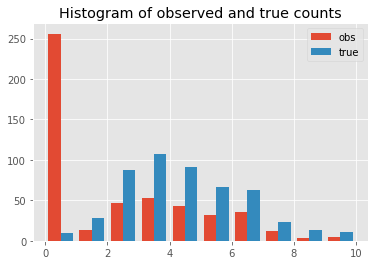

In [5]:
plt.hist((obs, true_cnts), label=('obs', 'true'))
plt.title('Histogram of observed and true counts')
plt.legend()
plt.show()

In [6]:
# GaP Model
a = 2.0
b = 1.0
r = Gamma(a, b)
x = Poisson(rate=r * tf.ones([N,]))

In [7]:
# Use a log-normal approximation to the Gamma posterior
qr_gap = TransformedDistribution(
    distribution=Normal(tf.Variable(tf.ones([])), tf.nn.softplus(tf.Variable(0.1 * tf.ones([])))),
    bijector=tf.contrib.distributions.bijectors.Exp())

inference = ed.KLqp({r: qr_gap}, data={x: obs}) # implicitly marginalize h out with a single sample from p(h)

inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

loss = np.empty(inference.n_iter)
for i in range(inference.n_iter):
    info_dict = inference.update()
    inference.print_progress(info_dict)
    loss[i] = info_dict["loss"]

/home/pedro/IST/Thesis/edward-venv/lib/python3.5/site-packages/edward/util/random_variables.py:50: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


1000/1000 [100%] ██████████████████████████████ Elapsed: 6s | Loss: 1190.791


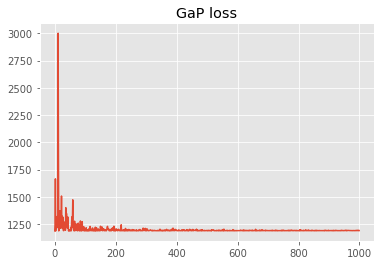

In [8]:
plt.plot(loss)
plt.title('GaP loss')
plt.show()

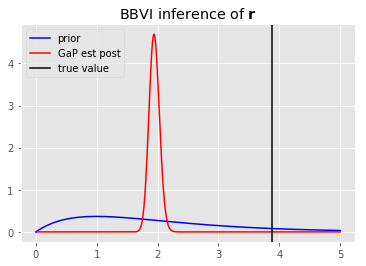

In [9]:
n_samples = 1000

xs = np.linspace(0, np.ceil(rate + 1.), n_samples).astype('float32')
qr_gap_probs = qr_gap.prob(xs).eval()

plt.plot(xs, r.prob(xs).eval(), label='prior', color='b')
plt.plot(xs, qr_gap_probs, label='GaP est post', color='r')
plt.axvline(x=rate, c='black', label='true value')
plt.legend()
plt.title('BBVI inference of $\mathbf{r}$')
plt.show()

In [10]:
# ZIP Model
a = 2.0
b = 1.0
p = 0.5
temp = 0.9
r = Gamma(a, b)
h = RelaxedBernoulli(temperature=temp, probs=p * tf.ones([N,]))
x = Poisson(rate=r * (1. - tf.cast(h, tf.float32)))

In [11]:
# Use a log-normal approximation to the Gamma posterior
qr_zip = TransformedDistribution(
    distribution=Normal(tf.Variable(tf.ones([])), tf.nn.softplus(tf.Variable(0.1 * tf.ones([])))),
    bijector=tf.contrib.distributions.bijectors.Exp())

inference = ed.KLqp({r: qr_zip}, data={x: obs}) # implicitly marginalize h out with a single sample from p(h)

inference.initialize()

tf.global_variables_initializer().run()

loss = np.empty(inference.n_iter)
for i in range(inference.n_iter):
    info_dict = inference.update()
    inference.print_progress(info_dict)
    loss[i] = info_dict["loss"]

/home/pedro/IST/Thesis/edward-venv/lib/python3.5/site-packages/edward/util/random_variables.py:50: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


1000/1000 [100%] ██████████████████████████████ Elapsed: 6s | Loss: 1471.086


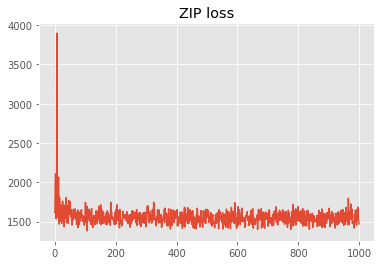

In [12]:
plt.plot(loss)
plt.title('ZIP loss')
plt.show()

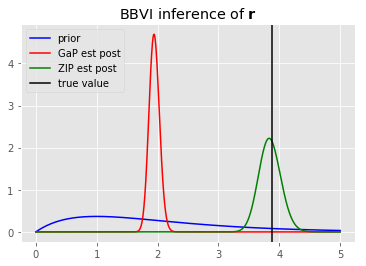

In [13]:
n_samples = 1000

xs = np.linspace(0, np.ceil(rate + 1.), n_samples).astype('float32')

plt.plot(xs, r.prob(xs).eval(), label='prior', color='b')
plt.plot(xs, qr_gap_probs, label='GaP est post', color='r')
plt.plot(xs, qr_zip.prob(xs).eval(), label='ZIP est post', color='g')
plt.axvline(x=rate, c='black', label='true value')
plt.legend()
plt.title('BBVI inference of $\mathbf{r}$')
plt.show()

In [14]:
np.mean(obs)

1.942

In [15]:
np.mean(true_cnts)

3.932